In [60]:
# from kcorrect.kcorrect import Kcorrect
import pandas as pd
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText

path = '/home/gimena/Documents/hsc/scripts/add_features/'  #of this file

### Create yanny files 

In [2]:
# import kcorrect
# sorted(kcorrect.response.all_responses())

filter_files = [# list of files with response functions (from https://hsc.mtk.nao.ac.jp/ssp/survey/#filters_and_depths)
    'hsc_g_v2018',
    'hsc_r2_v2018',
    'hsc_i2_v2018',
    'hsc_z_v2018',
    'hsc_y_v2018'
]

In [ ]:
table_names = ['GFILTER', 'RFILTER', 'IFILTER', 'ZFILTER', 'YFILTER']

# convert them to yanny parameter files...
# Kcorrect does have some response functions for subaru, but it's missing the Y filter. Also, the i and r filters were changed in 2016 (see HSC-SSP DR2 note).
responses = []
for fil,nam in zip(filter_files,table_names):
    f = pd.read_table(f'hsc_responses_all_rev4/{fil}.dat', names = ['w','r'], sep='\s+')
    f.insert(0, 'a', nam)  #name of the table
    
    with open(f'par_responses/{fil}.par', 'w') as par:
        par.write('typedef struct {\n')
        par.write(' float lambda;\n')
        par.write(' float pass;\n')
        par.write('} '+nam+';\n\n')

        dfAsString = f.to_string(header=False, index=False)
        par.write(dfAsString)
del f,fil

### Create Kcorrect instance and fit coefficients. Check distribution and errors.

In [27]:
# list of par files for each filter, with ABSOLUT PATH
responses = [path + 'par_responses/' + fil for fil in filter_files]
kc = Kcorrect(responses = responses, abcorrect= False, redshift_range= [0., 5], nredshift = 7000, cosmo= FlatLambdaCDM(H0=70, Om0=0.3))

# I increased the upper limit for redshift, to be able to compute absolute magnitudes with a band shift later

In [4]:
df = pd.read_csv('../../HSC-unWISE-W02.csv')
magnitudes = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
errors = ['g_cmodel_magsigma', 'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma', 'y_cmodel_magsigma']
absorption = ['a_g', 'a_r', 'a_i', 'a_z', 'a_y']  

In [7]:
# convert the magnitudes to "maggies"
# maggies are a linear flux density unit defined as 10^{-0.4 m_AB}  where  m_AB is the AB apparent magnitude. 
# That is, 1 maggie is the flux density in Janskys divided by 3631. 

# https://www.sdss3.org/dr8/algorithms/magnitudes.php
# http://wiki.ipb.ac.rs/index.php/Astro_links

maggies = pd.DataFrame()
ivars = pd.DataFrame()
for mag,err,ab in zip(magnitudes, errors, absorption):
    maggies[mag] = [10**(-0.4 * (m - a)) for m,a in zip(df[mag].values, df[ab].values)]     # 10^[-0.4 * (m - a_ext)]
    ivars[mag]=[1./(0.4*np.log(10.)*maggie*e)**2 for e,maggie in zip(df[err].values, maggies[mag].values)]   # 1. / [0.4 * ln(10) * maggie * m_err]**2

In [8]:
coeffs,rnorms = kc.fit_coeffs(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, errors = True)  
# the docs says that it transforms maggies to the ab system.

# “NNLS quitting on iteration count.” 
# This indicates that the default number of iterations for scipy.optimize.nnls was not enough. 
# Under these conditions, this code tries a much larger number of iterations. If that still fails, you will receive a traceback.

# I edited kcorrect so that it returned the rnorms (but i don't think it is important).


 NNLS quitting on iteration count.


Text(0.5, 0, 'coeffs')

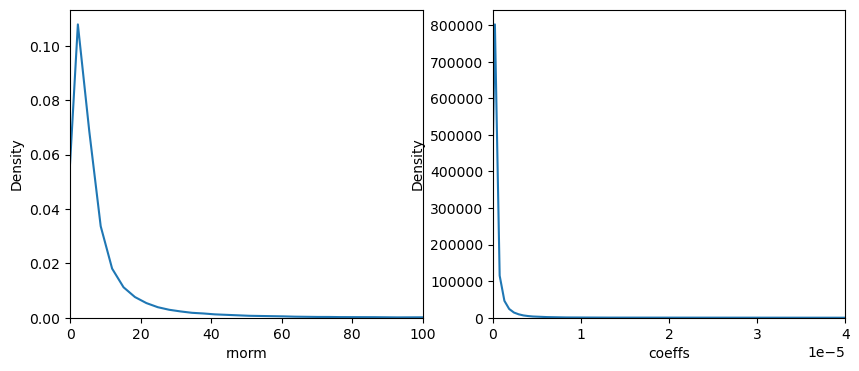

In [9]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(x = rnorms)
plt.xlim(0,100)
plt.xlabel('rnorm')

plt.subplot(1, 2, 2)
sns.kdeplot(x = coeffs.flatten())
plt.xlim(0,0.00004)
plt.xlabel('coeffs')

### Without bandshift

#### K-correction and distribution as function of z

In [10]:
kcorr = kc.kcorrect(redshift = df['phot_z'].values, coeffs = coeffs)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_k_corr'] = kcorr[:,i]

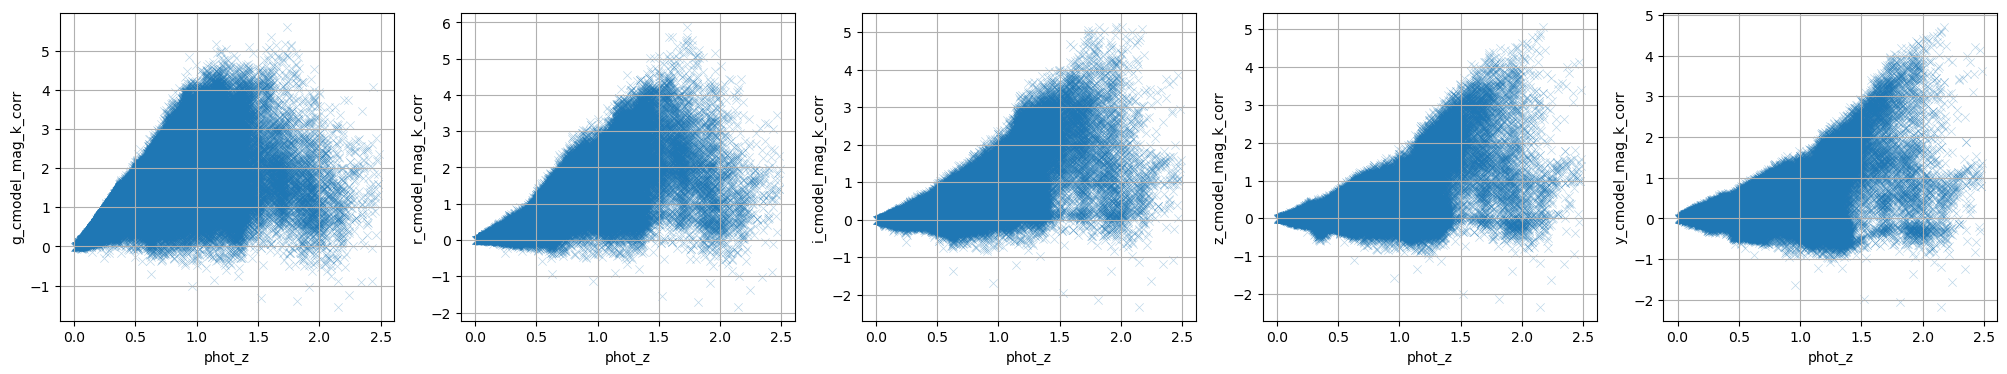

In [11]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.scatterplot(data = df, x = 'phot_z', y = magnitudes[i] + '_k_corr', marker = 'x', alpha = 0.3)
    plt.grid()

#### Absolute magnitudes.

In [12]:
abs_mags = kc.absmag(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, coeffs = coeffs)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_abs'] = abs_mags[:,i]

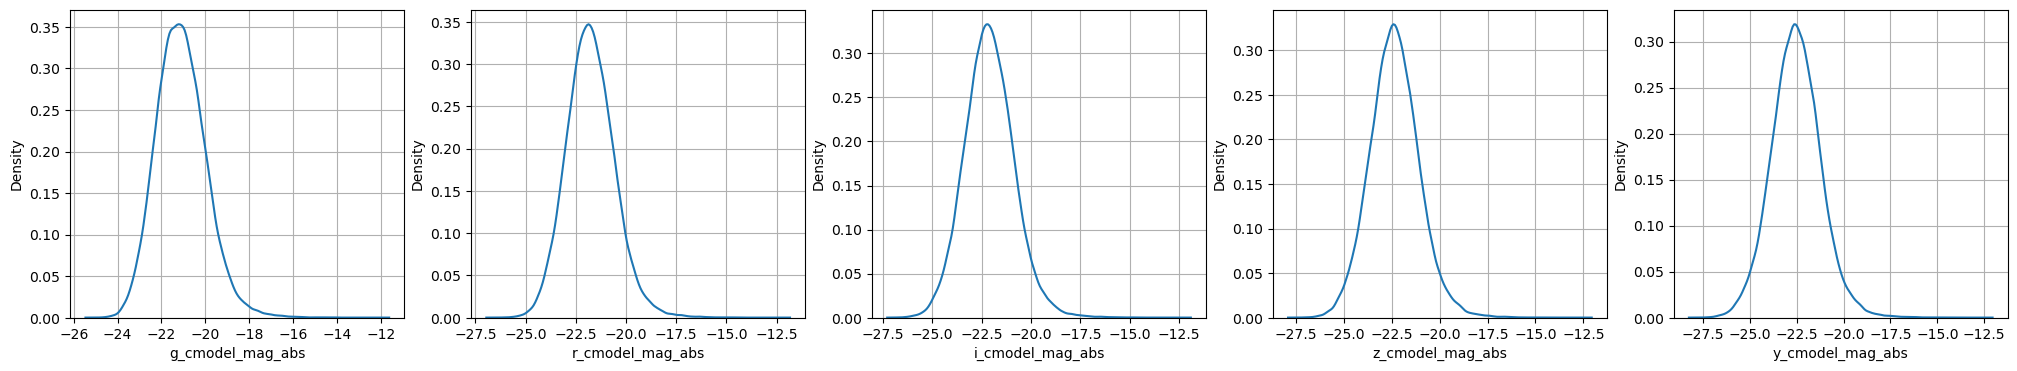

In [13]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.kdeplot(data = df, x = magnitudes[i] + '_abs')
    plt.grid()

### With bandshift

#### K-corrections with bandshift. Distribution plots. 

Mean:  0.726485642719
Median:  0.667


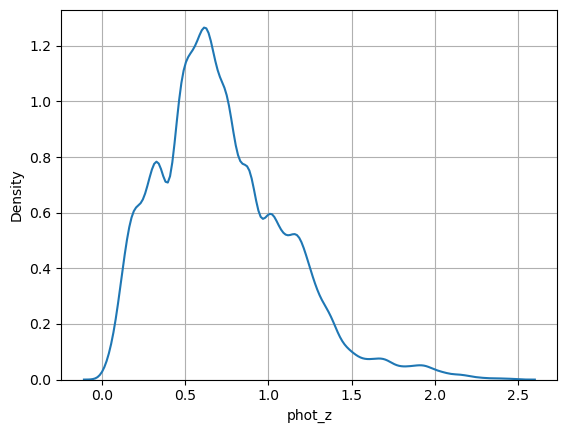

In [15]:
# check z distribution and mean value
sns.kdeplot(data = df, x = 'phot_z')
plt.grid()
print('Mean: ', np.mean(df.phot_z.values))
print('Median: ', np.median(df.phot_z.values))

In [16]:
shift = np.median(df.phot_z.values)
kcorr_shift = kc.kcorrect(redshift = df['phot_z'].values, coeffs = coeffs, band_shift= shift)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_k_corr_shift'] = kcorr_shift[:,i]

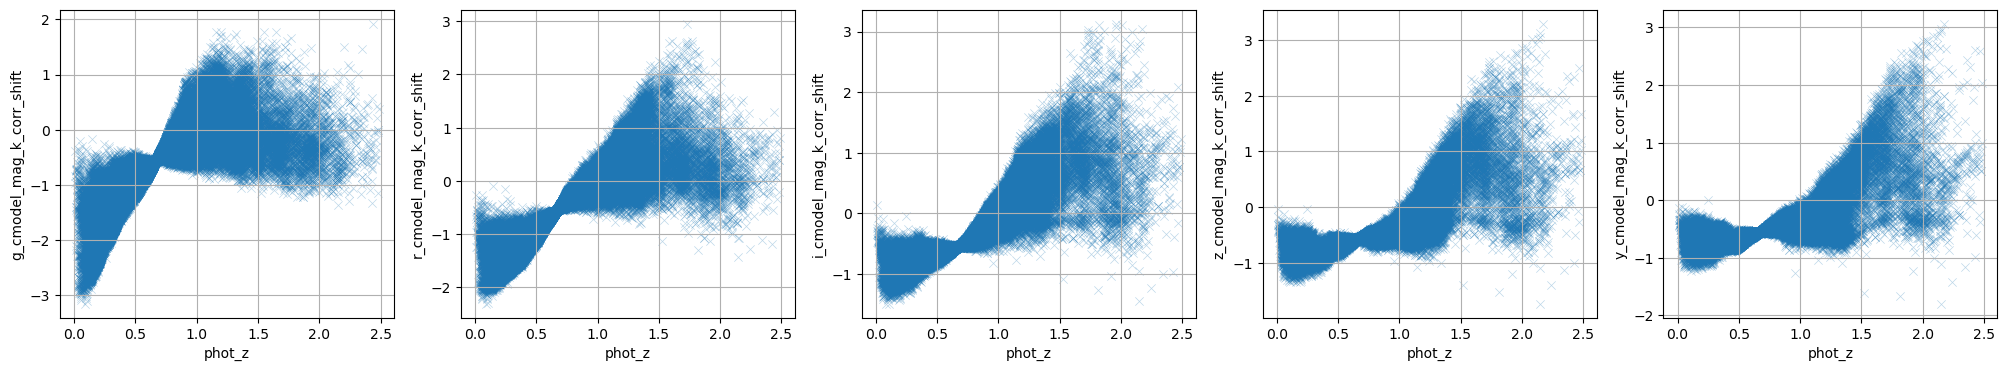

In [17]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.scatterplot(data = df, x = 'phot_z', y = magnitudes[i] + '_k_corr_shift', marker = 'x', alpha = 0.3)
    plt.grid()

In [18]:
# from kcorrect.org

# for a bandpass shifted by z_0, the K-correction for a galaxy at z_0 to the observed bandpass shifted by z_0 is −2.5log10(1+z_0), independent of galaxy SED. 

# in this case, this is:
print(-2.5 * np.log10(1 + shift))

-0.55483899957


#### Absolute magnitudes with bandshift

In [28]:
abs_mags_shift = kc.absmag(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, coeffs = coeffs, band_shift= shift)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_abs_shift'] = abs_mags_shift[:,i]
    
# idk why this does not work. 

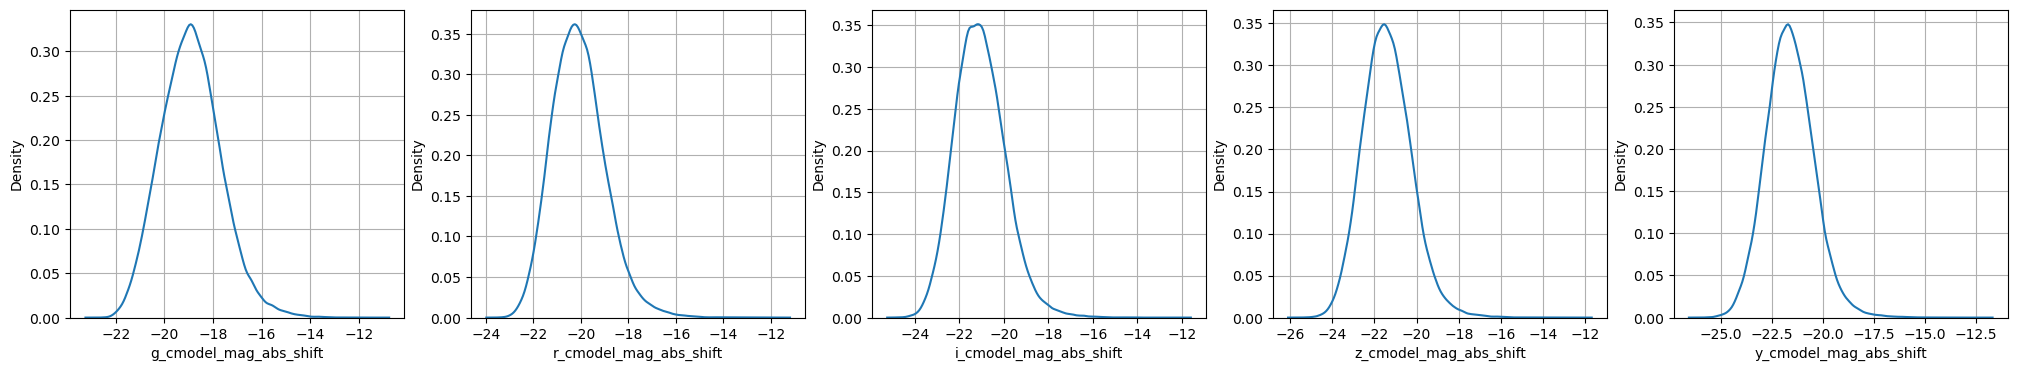

In [29]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.kdeplot(data = df, x = magnitudes[i] + '_abs_shift')
    plt.grid()

### CSV

In [31]:
df.to_csv('clean-HSC-unWISE-W02--kcorr_tests.csv')

In [2]:
df = pd.read_csv('clean-HSC-unWISE-W02--kcorr_tests.csv')

### Color-magnitude plots in redshift bins

In [3]:
df_cl = pd.read_table('../../clusters.dat', sep='\s+', usecols=[0,5],  names=['id_cl','phot_z_cl'])
#  usecols=[0,3,4,5,9,11,12],  names=['id_cl','ra_cl','dec_cl','phot_z_cl', 'r500_cl','mass_cl','n500_cl']

df_ = pd.DataFrame()
df_['id_cl_near_eval'] = [eval(p)[0] for p in df.id_cl_near.values]
df_['z_cl'] = [df_cl[df_cl.id_cl == i]['phot_z_cl'].values[0] for i in df_.id_cl_near_eval]

In [4]:
min_ = 0.
max_ = 1.4
step = 0.2
n_bins = round((max_ - min_)/step)
z_centers = np.linspace(min_ + step/2., max_ - step/2., n_bins)
z_lims = np.linspace(min_, max_, n_bins + 1)

print(z_centers)
print(z_lims)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4]


In [98]:
def col_mag(magnitude1, magnitude2, clim, mlim, sample = 1000):
    plt.figure(figsize = (20, 4.*math.ceil(n_bins/4.)))

    for i_z,z in enumerate(z_centers):
        cond = (df_.z_cl > z - step/2. ) & (df_.z_cl < z+step/2. )
        mem = df[(df.member == 1) & cond] 
        nmem = df[(df.member == 0) & cond] # contour plot takes forever. use sample
        nmem_sam = nmem.sample(n = sample, axis = 'index')

        plt.subplot(int(math.ceil(n_bins/4.)), 4, i_z+1)
        sns.scatterplot(y = nmem[magnitude1] - nmem[magnitude2], x = nmem[magnitude2], marker = '+', alpha = 0.1, color = 'grey', zorder = 1,  label = 'Non-members')
        sns.kdeplot(y = nmem_sam[magnitude1] - nmem_sam[magnitude2], x = nmem_sam[magnitude2], levels = 8, color = 'grey', zorder = 2)
        sns.scatterplot(y = mem[magnitude1] - mem[magnitude2], x = mem[magnitude2], marker = '+', alpha = 0.1, label = 'Members', color = 'indigo', zorder = 3)
        
        plt.grid()
        plt.xlabel(f'{magnitude2}')
        plt.ylabel(f'{magnitude1} - {magnitude2}')
        plt.ylim(clim)
        plt.xlim(mlim)
        plt.title(f'{z - step/2 :.1f} < z < {z + step/2 :.1f}')

        fit = linregress(mem[magnitude2].values, mem[magnitude1].values - mem[magnitude2].values)
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = fit[1] + fit[0] * x_vals
        plt.plot(x_vals, y_vals, ls = '--', color = 'indigo')

        text = f'slope: {fit.slope :.3f} +/- {fit.stderr :.3f}\nintercept: {fit.intercept :.3f} +/- {fit.intercept_stderr :.3f}'
        text_box = AnchoredText(text, frameon=True, loc=4, pad=0.5)
        plt.setp(text_box.patch, facecolor='white', alpha=0.5)
        plt.gca().add_artist(text_box)

    plt.tight_layout()    
    plt.show()

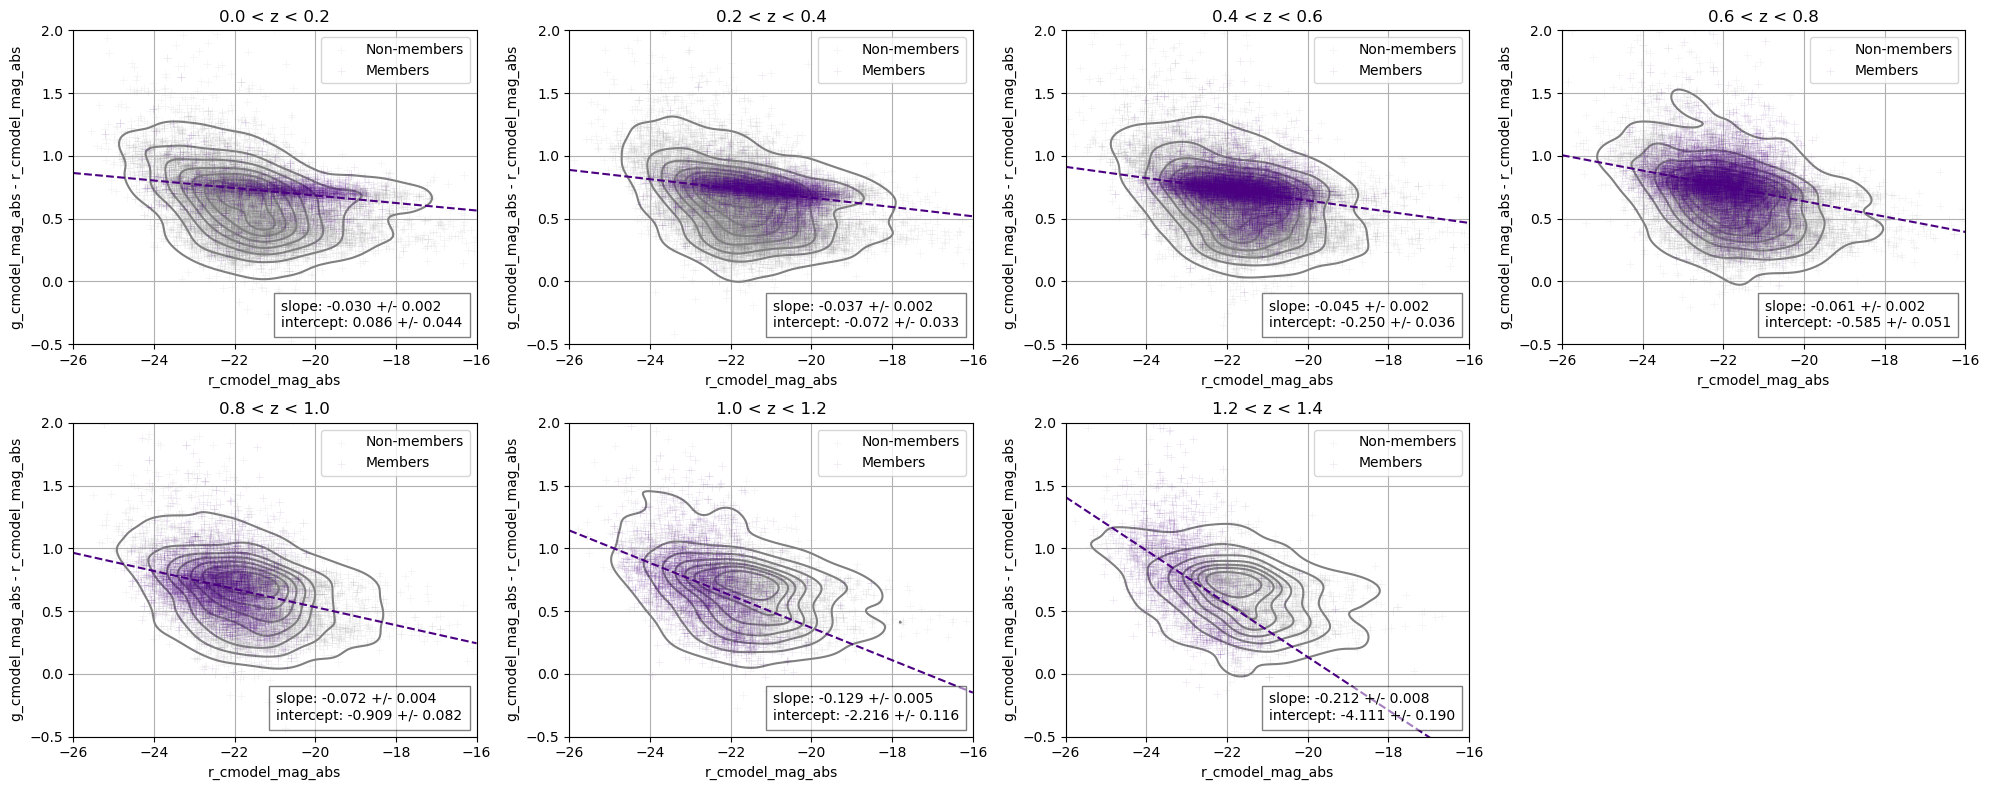

In [99]:
col_mag('g_cmodel_mag_abs', 'r_cmodel_mag_abs', (-0.5, 2.), (-26,-16))

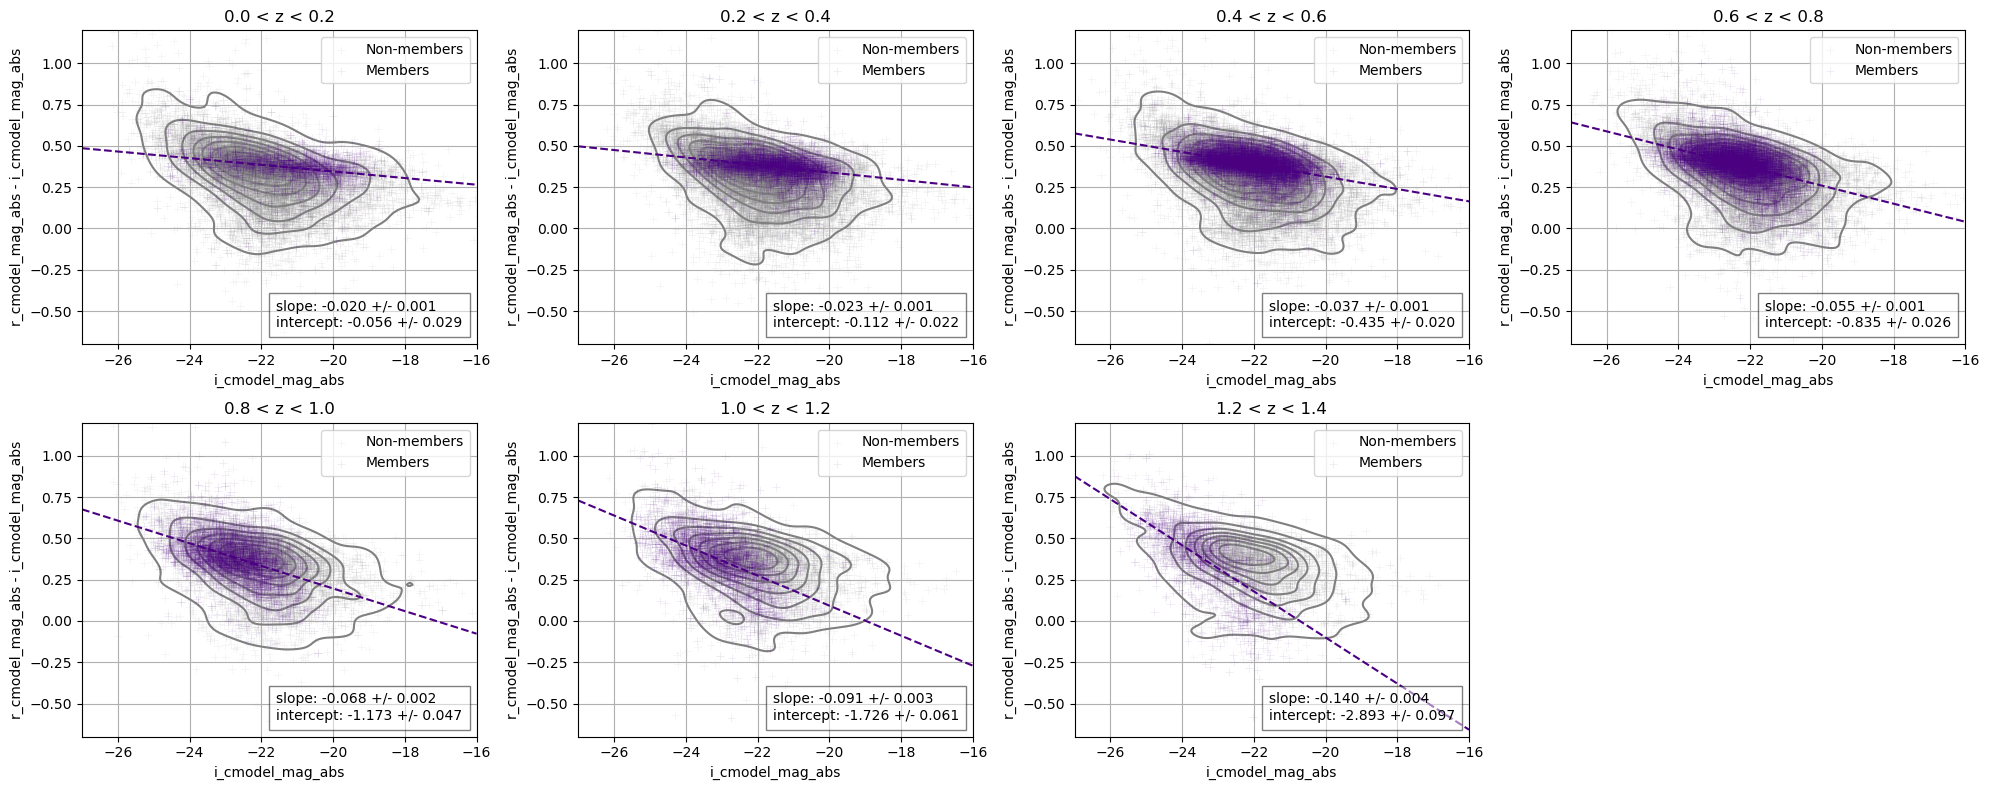

In [100]:
col_mag('r_cmodel_mag_abs', 'i_cmodel_mag_abs', (-0.7, 1.2), (-27,-16))

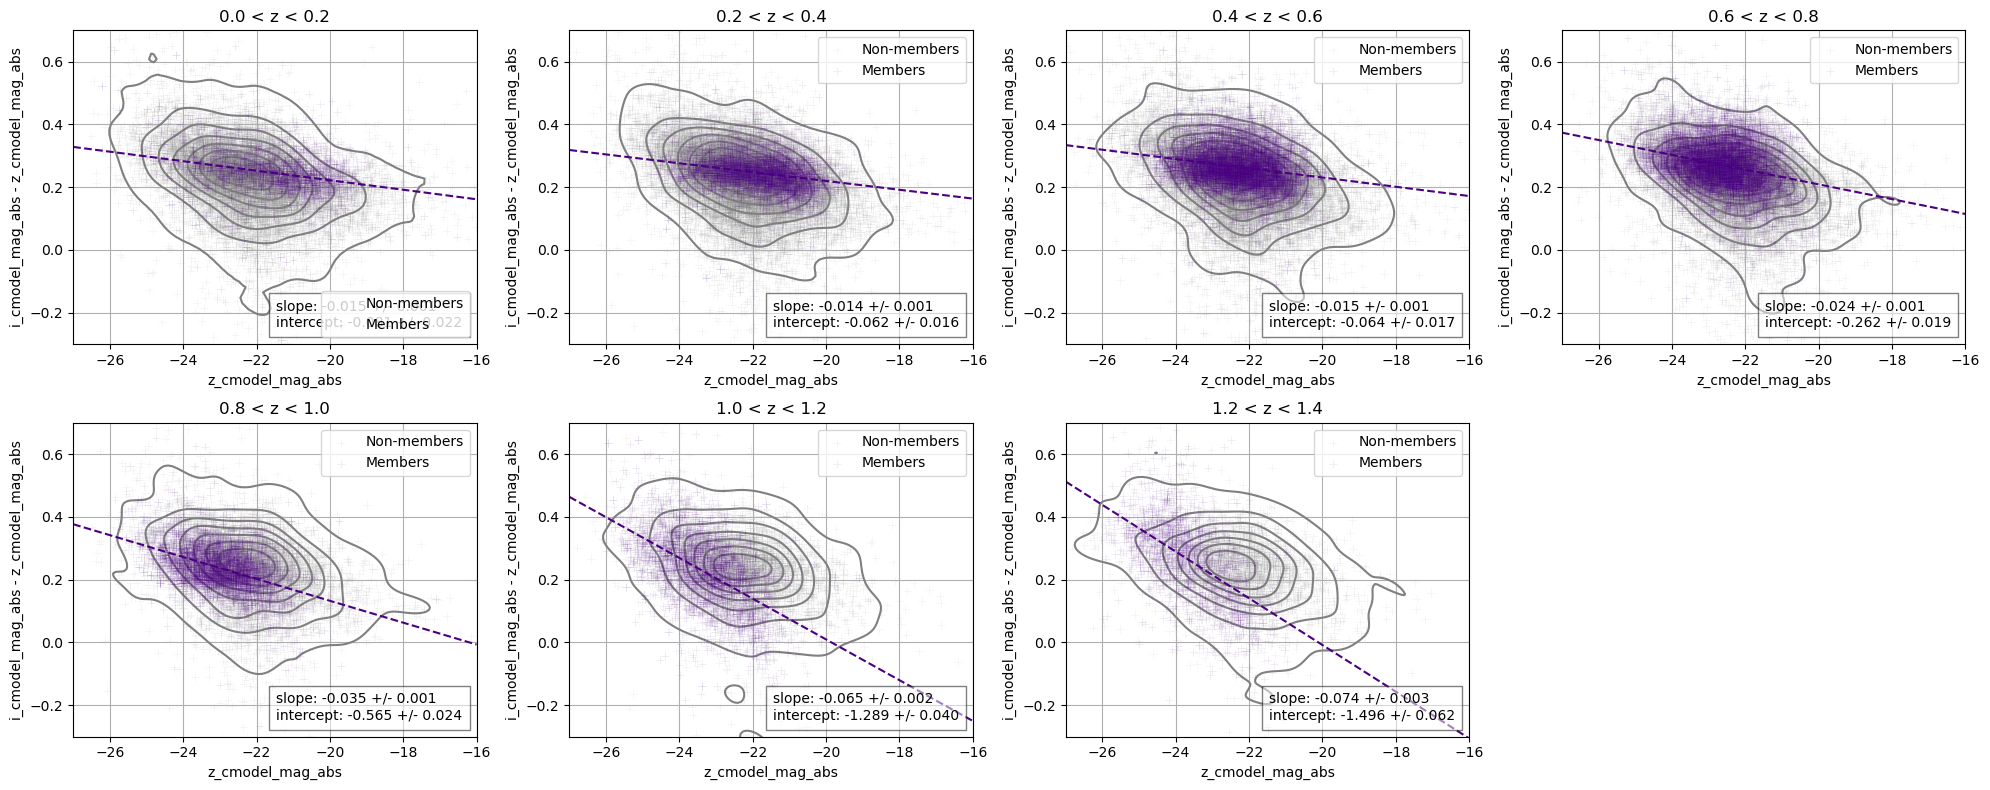

In [101]:
col_mag('i_cmodel_mag_abs', 'z_cmodel_mag_abs', (-0.3, 0.7), (-27,-16))

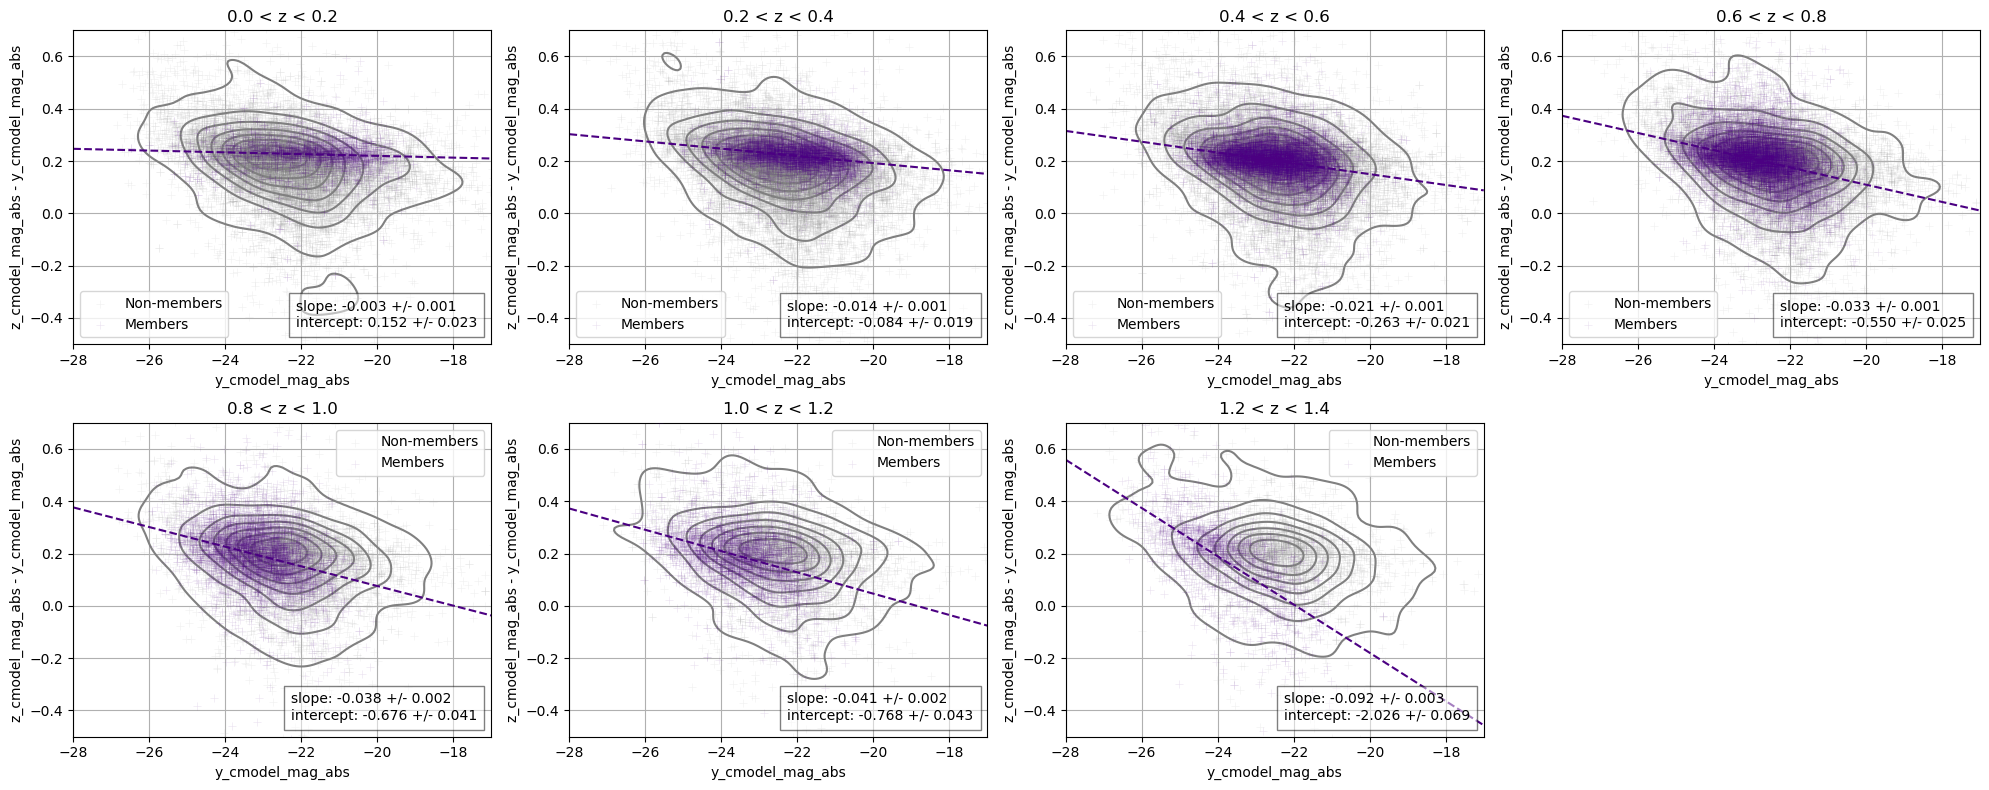

In [102]:
col_mag('z_cmodel_mag_abs', 'y_cmodel_mag_abs', (-0.5, 0.7), (-28, -17))